# Project 2 - Forecast correction

## General Overview

### Understand Assignment
https://www.ecmwf.int/en/newsletter/166/meteorology/statistical-post-processing-ensemble-forecasts-belgian-met-service
- Given 2023 discrepancies between forecast and actual values, what will the temperatures be at the vlinder station in 2024?
    - Seems that temperaturs at vlinder station tend to be hotter than the forecast

- The ensemble mean of the corrected forecast is a linear function of the ensemble mean(s) of the predictor(s)
- direct output from computer simulations of the atmosphere needs calibration before it can be meaningfully compared with observations of weather variables. This calibration process is often known as model output statistics (MOS). The simplest form of such calibration is to correct biases, using a bias correction calculated from past forecast errors

### Data Preprocessing
- [x] Add data from all the forecasts of 2023
    - We dont especially need to avoid duplicate data, we can keep it
- [ ] Use past data pf 2024 to add to training data
- What data do we keep for selection [Feature Selection](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)?
    - Data selection will depend on algo used
        - We need to create a dataframe that holds all the different forecasts grouped by start date. We can then combine them as required for the different ML algorithmes. We need to do the train/validation/test sets as earlier as possible, in order to validate our algorithmes on the same data. (does this actually matter ?)   
    - correlation analysis/feature importance ranking/Principal Component Analysis 
    - At what level of correletion do i keep my values?
    - Simple regression on t2m sufficient?
- Sync data: vlinder:
    - [x] need same time frame than Forecast -> need a way to get it directly from the max and min of forecast csv
    - [x] merge because of time stamps (do i take the mean of tmp on elapsed period or precise timestamp ?)
- How to treat small vlinder data set?
- Rounding errors in ecmwf t2m data?
- RandomForest Regressor
- Nonhomogeneous Gaussian regression

### Algo/training

- Look at the difference from one day to the other in forecast (instead of computing absolute values)
- Use the difference between forecast tmp and predicted temp to analyze other variables (heat island effect)
- Use a Neural net where inputs are different timestamps for each forecast

### Nice things to have
- [ ] Use pipelines to automate operations
- [x] Consumption of energy + log
- [ ] Time function (+ display number of training samples) 

### Misc
- Name of station ? ecmwf? station?
- All of the data visualization is happening on the whole set, no split atm probably not good

In [1]:
%pip install codecarbon

Note: you may need to restart the kernel to use updated packages.


In [2]:
from codecarbon import track_emissions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import glob
import datetime
from functools import partial
# 0 degre Celius in Kelvin
C_0 = 273.15
#Dict to link target metrics from forecast with an eventual required scaling constant
Const_Conversion = {'t2m' : C_0, 'd2m' : C_0, 'skt' : C_0}
plt.style.use('seaborn-v0_8-colorblind')

# Match data sets
Need to resample data from the vlinder station to match the measurements of the forecast.
- We add all the different forecasts in one dataframe
    - Need to be carefull with duplicate data (does it matter to take the days of the same ensemble forecast?) 
- Resample on frequency, vlinder measures every 5 minutes where as the forecast is given for every 6 hours
- Resize on time frame, we need our ensemble forecast timestamps to match measurements at vlinder station
    - Need to match data of vlinder station

In [181]:
# Create of Main DataFrame
class EnsembleForecast:
    def __init__(self):
        self.df = self._create_df()

    def _extract_datetime(self, file_name):
        """
            Extracts datetime object from file_name 
            Returns datetime if successful, None otherwise
        """
        try:
            strings_of_date = file_name.replace('.', '_').split('_')[1:4]
            d, m, y = tuple(map(int, strings_of_date))
            return datetime.datetime(y, m, d)
        except Exception as e:
            print(f"Forecast csv does not respect date_month_year.csv format: {e}\n {file_name} dropped")
        return None


    # TODO: create multi index on start time and then on forecast time
    def _create_df(self):
        """
            Creates dataframe where each ensemble forecast is accessible by its start date
        """
        df_f = pd.DataFrame()
        for file_name in glob.glob("forecast/"+'*.csv'): 
            start_time = self._extract_datetime(file_name)
            if start_time != None:
                to_add = pd.read_csv(file_name)
                to_add['Start'] = start_time
                df_f = pd.concat([df_f, to_add])
            else:
                pass
        df_f = df_f.sort_values(by='Start', kind='mergesort')
        return df_f.set_index(['Start', 'time']).sort_index()

    def get_df(self):
        return self.df

    def get_start_dates(self):
        """
            Returns a list start date of ensemble forecast
        """
        lst = list(set(self.df.index.get_level_values('Start')))
        lst.sort()
        return lst

    def get_ensemble_forecast(self, date):
        """
            Returns ensemble forecast given date
            date can be either a string
                date format (%Y-%M-%D %h:%m:%s)
            or already a timestamp object
        """
        return self.df.loc[date]

forecast_data = EnsembleForecast()

df_fc = forecast_data.get_df()

test = forecast_data.get_start_dates() 
test
df_1 = forecast_data.get_ensemble_forecast("2023-03-01 00:00:00")
df_1

,number,latitude,longitude,cape,sp,tcw,sshf,slhf,msl,u10,...,skt,cin,sm,st,sd,sf,tcc,tp,mx2t6,mn2t6
time,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,1,50.75,4.25,0.000000,102126.210,6.714889,-117.5,-127.0,103096.090,-0.985653,...,269.20410,NaN,347.42044,275.79584,0.000000,0.000000,1.556484,9.536743e-07,NaN,NaN
2023-03-01 00:00:00,2,50.75,4.25,0.000000,102133.650,6.498146,-117.5,-127.0,103103.970,-1.522217,...,269.66020,NaN,338.56020,275.89400,0.000000,0.000000,0.000000,9.536743e-07,NaN,NaN
2023-03-01 00:00:00,3,50.75,4.25,0.000000,102119.945,6.799605,-117.5,-127.0,103089.580,-1.284668,...,269.31256,NaN,350.98910,275.68307,0.000000,0.000000,0.781292,9.536743e-07,NaN,NaN
2023-03-01 00:00:00,4,50.75,4.25,0.000000,102120.590,7.023780,-117.5,-127.0,103091.086,-1.273917,...,269.56317,NaN,358.10077,275.86673,0.000000,0.000000,0.781292,9.536743e-07,NaN,NaN
2023-03-01 00:00:00,5,50.75,4.25,0.000000,102109.240,6.827844,-117.5,-127.0,103079.080,-1.361147,...,269.51580,NaN,340.47208,275.64920,0.000000,0.000000,1.556484,9.536743e-07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-08 00:00:00,46,50.75,4.25,0.000000,99471.070,6.518210,-6912008.5,-14481851.0,100420.445,2.477168,...,268.39005,NaN,343.22794,274.76828,2.716805,3.994299,97.988220,8.606507e+00,272.77350,270.14700
2023-03-08 00:00:00,47,50.75,4.25,8.956787,99693.320,5.953935,-6728274.0,-15024982.0,100647.520,2.178558,...,268.41483,NaN,341.23718,274.57004,3.035020,3.370245,92.465760,6.787576e+00,271.72372,269.75140
2023-03-08 00:00:00,48,50.75,4.25,0.000000,98548.660,5.382476,-7861220.5,-13501546.0,99493.200,2.923866,...,269.33440,NaN,341.71057,274.84042,0.840019,1.177577,99.999435,4.380313e+00,273.94190,270.52480


## Vlinder Data

Vlinder data set is inside a Vlinder class. This makes it easier to query and display subsets of data

We need to check for inconsitent data points in the the vlinder set and then resample it to match the ensemble forecast

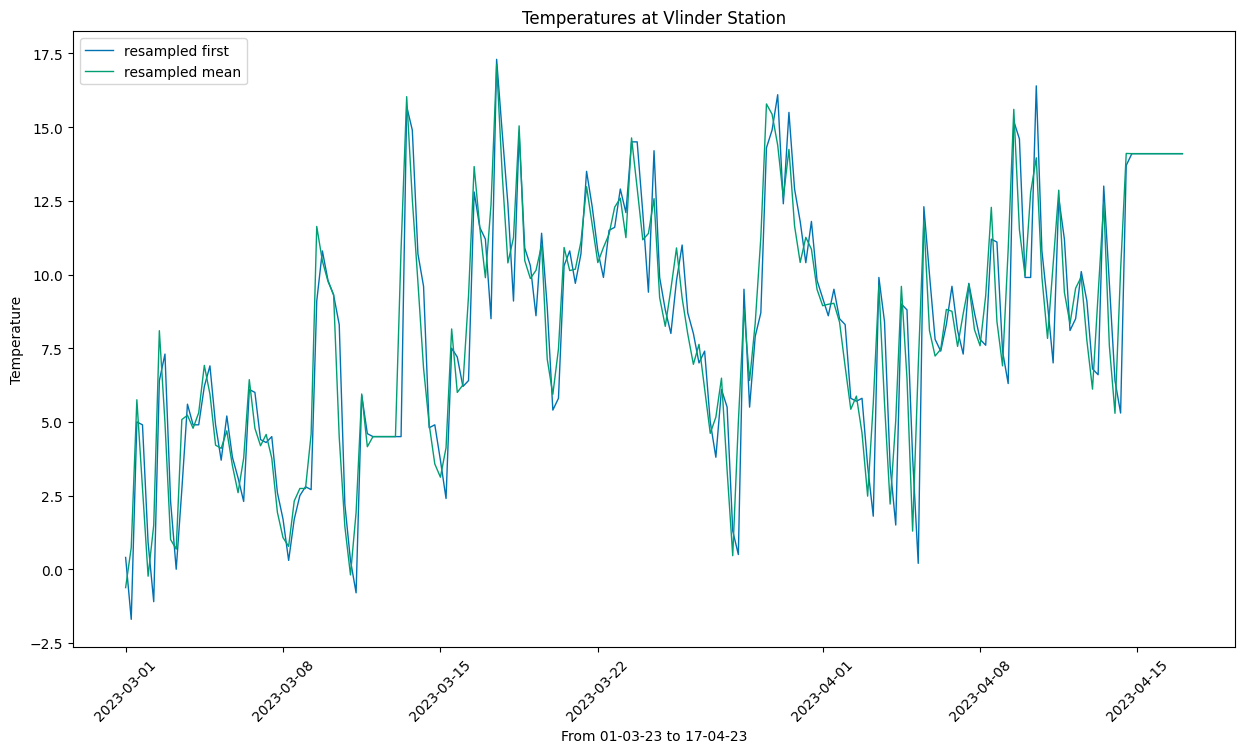

In [152]:
#TODO: could also modify resampling rate to make it more modular 
class Vlinder: 
    """
        Class that represents Vlinder data
        Holds original data in self.df 
        Holds resampled data in self.resample
    """
    def __init__(self, path_to_csv):
        self.df = pd.read_csv(path_to_csv)
        self.temp_str = self.df.columns.tolist()[0]
        self.time_str = self.df.columns.tolist()[1]
        
        self.df[self.time_str] = pd.to_datetime(self.df[self.time_str])
        
        self.resample = {"first" :  self.df.set_index(self.time_str).resample('6h').first().reset_index(),
                        "mean" : self.df.set_index(self.time_str).resample('6h').mean().reset_index()}

    def _apply_dates_resize(self, first, snd):
        """
            Does a partial application of dates as we often want the same dates for different dataframes
        """
        return partial(self.resize_on_time, start=first, finish=snd)

    #TODO refactore horrible code
    def _get_time(self, df, start, finish):
        """
            Helper function to set start and finish to the min
            Start and finish can be either None, string or datetime
            Returns datetime object
        """
        if start is None: 
            start = self.earliest(df)
        elif isinstance(start, str):
            start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        else: 
            pass
        if finish is None: 
            finish = self.latest(df) 
        elif isinstance(finish, str):
            finish = datetime.datetime.strptime(finish, "%Y-%m-%d %H:%M:%S")
        else:
            pass
        return (start, finish)
        
    
    def dataframe_of_string(func):
        """
            Decorator function used to convert input dataframe string into actual dataframe
            If passed in argument is already a dataframe does nothing and passes data framethrough
            Carefull: input type is a string, new type is a dataframe
        """
        def wrapper(self, type="df", *args, **kwargs):
            if isinstance(type, str):
                type = self.select_type(type)
            return func(self, type, *args, **kwargs)
        return wrapper

    #Does not work well when chaining decorators together => Unused atm
    def handle_time(func):
        """
            Decorator used to handle start and finish times
        """
        def wrapper(self, *args, **kwargs):
            if start is None:
                start = self.earliest()
            if finish is None:
                finish = self.latest()
            return func(self, df, start, finish, *args, **kwargs)
        return wrapper

    
    def select_type(self, type="df"):
        """
            Returns dataframe corresponding to type
            types available: 
            - df : original dataframe
            - mean : dataframe resampled on mean
            - first : dataframe resampled on first
        """
        df = None
        match type:
            case "df":
                df = self.df
            case "mean":
                df = self.resample["mean"]
            case "first":
                df = self.resample["first"]
            case _ :
                raise ValueError(f"dataframe {type} does not exist")
        return df
    
    @dataframe_of_string
    def earliest(self, type="df"):
        """
            Returns earliest date in dataframe
        """
        return min(type[self.time_str])

    @dataframe_of_string
    def latest(self, type="df"):
        """
            Returns latest date in dataframe
        """
        return max(type[self.time_str])

    def plot(self, start=None, finish=None):
        """
            Plots original data points as well as resampeled on mean and first
        """
        start , finish = self._get_time(self.df, start, finish)

        # partial application of dates
        select_df = self._apply_dates_resize(start, finish)

        mean = select_df("mean")
        first = select_df("first")
        base = select_df("df")
        
        plt.figure(figsize=(15, 8))
        plt.plot(first[self.time_str], first[self.temp_str], label='resampled first', linewidth=1)
        plt.plot(mean[self.time_str], mean[self.temp_str], label='resampled mean', linewidth=1)
        #plt.plot(base[self.time_str], base[self.temp_str], label='original', linestyle='--', linewidth=0.7)
        plt.legend(loc='upper left')
        plt.xlabel(f"""From {start.strftime("%d-%m-%y")} to {finish.strftime("%d-%m-%y")}""")
        plt.ylabel('Temperature')
        plt.title(f'Temperatures at Vlinder Station')
        plt.xticks(rotation=45)
        plt.show()
    
    @dataframe_of_string
    def plot_one(self, type="df" , start=None, finish=None):
        """
            Plots one of the dataframes, either df, mean or first
        """
        start , finish = self._get_time(type, start, finish)
        df_resize = self.resize_on_time(type, start, finish)
        plt.figure(figsize=(15, 8))
        plt.plot(df_resize[self.time_str], df_resize[self.temp_str], label="df") #cannot use type as label as it has been changed to dataframe through decorator
        plt.legend(loc='upper left')
        plt.xlabel(f"""From {start.strftime("%d-%m-%y")} to {finish.strftime("%d-%m-%y")}""")
        plt.ylabel('Temperature')
        plt.title(f'Temperatures at Vlinder Station')
        plt.xticks(rotation=45)
        plt.show()

    @dataframe_of_string
    def resize_on_time(self, type="df", start=None, finish=None):
        """
            Returns new data frame with values between start and finish
            type specifies on which dataframe to apply resizing (df for original, mean for resample mean and first for resample first)
            Format (%Y-%M-%D %h:%m:%s)
            
            On why start and finish = None: https://stackoverflow.com/questions/1802971/nameerror-name-self-is-not-defined
        """
        start , finish = self._get_time(type, start, finish)
        assert start >= self.earliest(type), f"{start} does not exist in dataframe"
        assert finish <= self.latest(type), f"{finish} dies not exist in dataframe"
        return type[(type[self.time_str] >= start) & (type[self.time_str] <= finish)]  
        
vlinder_data = Vlinder('vlinder19_2023.csv')

#TODO change hard code of start and finish
#Plot vlinder data on time frame of forecast date avaiable
vlinder_data.plot(start="2023-03-01 00:00:00", finish="2023-04-17 00:00:00")

We can see from our resampled data that around the 15th april the vlinder data seems to be constant which indicates an error measurment

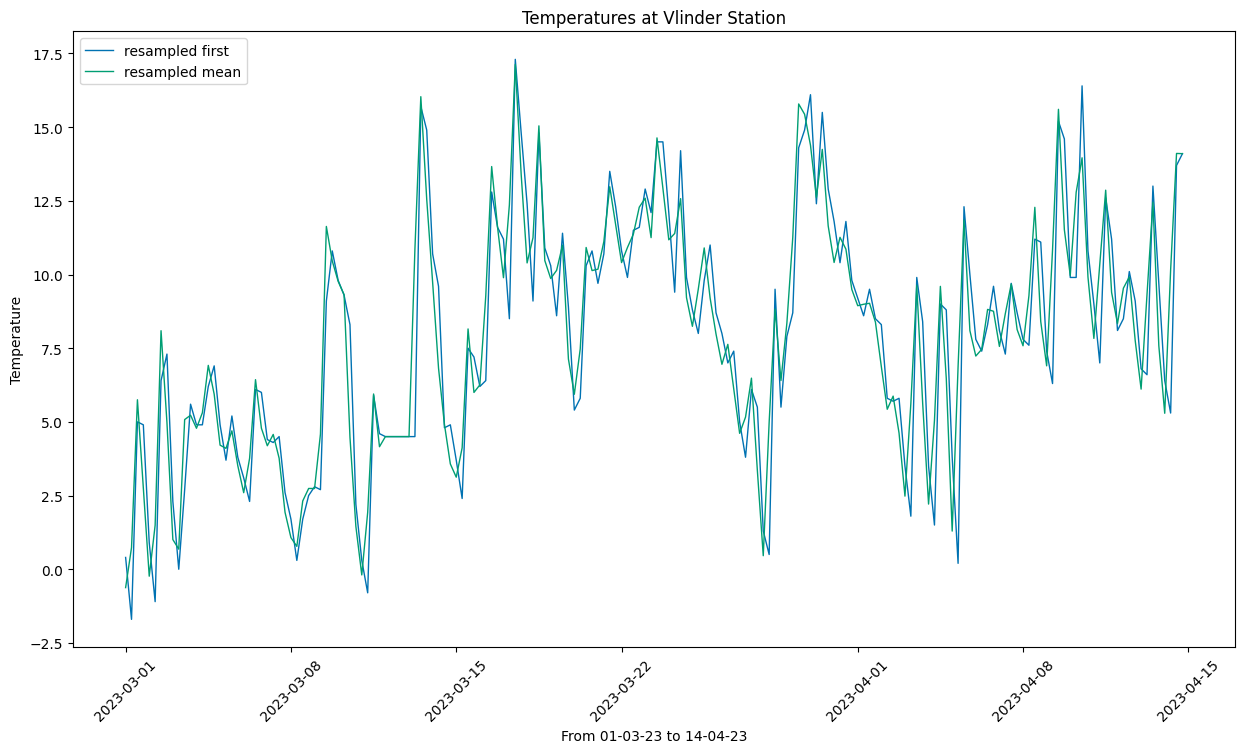

In [146]:
df_v.plot(start="2023-03-01 00:00:00", finish="2023-04-14 18:00:00")

`2023-04-14 18:00:00` seems to be a better time

In [147]:
MAX_VLINDER = "2023-04-14 18:00:00"

## Integrating Forecast and Vlinder Temperaturs
1. We need to know how to resample our Vlinder Data.
   - Compute the mean of 't2m' (which will be our explanatory variable) and correlated it to the ressampled vlinder data. We then choose the highest correlated resampling method
   - We can also choose here which time period we consider
2. We can then merge ensemble forecasts with observed vlinder data

### 1. Selection of resampling technique

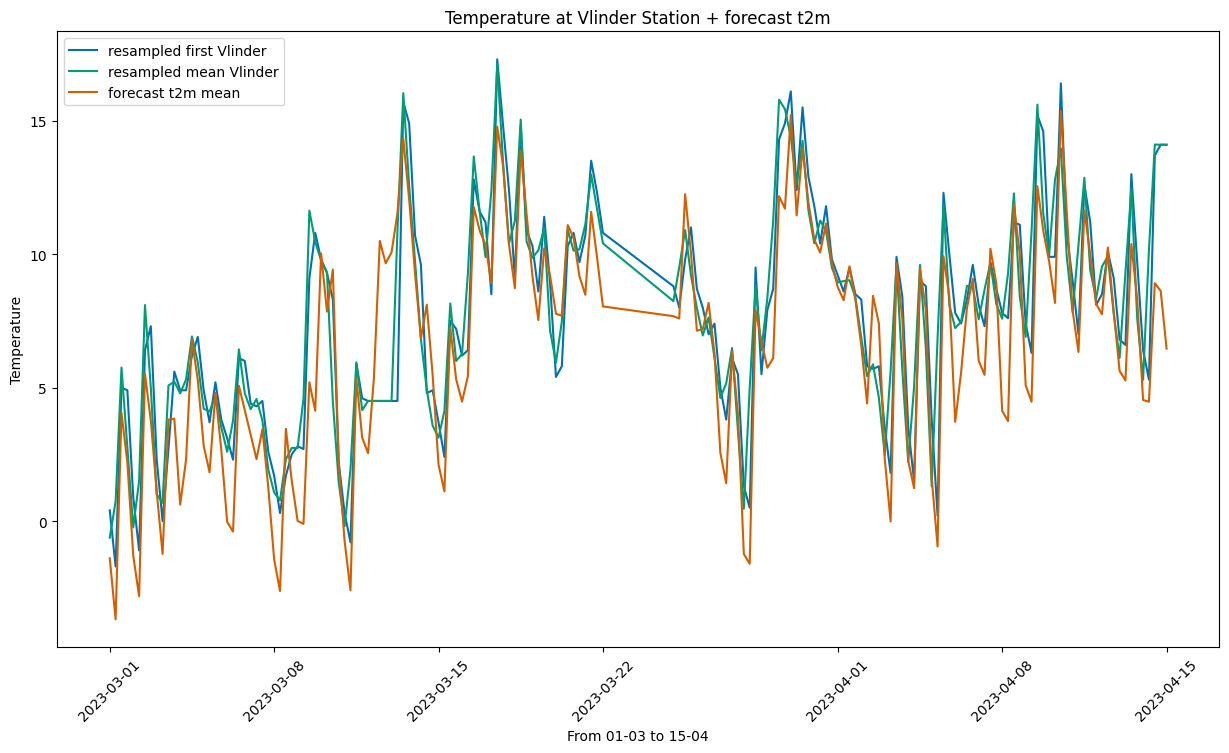

In [6]:
#get the mean value of a given datetime value on temperatures
#target column of forecast dataframe
target = 't2m'
ensmean_forecast = df_fc.groupby('datetime')[target].mean().reset_index()
ensmean_forecast[target] = ensmean_forecast[target] - Const_Conversion[target]

#Displays vlinder temperatures resampled on mean and first feature as well as an additional variable
def display_first_mean_additional(df_fc, additional):
    vlinder_res_first = resize_df_datetime(df_fc['datetime'].min(), df_fc['datetime'].max(), df_vlinder_res_first)
    vlinder_res_mean = resize_df_datetime(df_fc['datetime'].min(), df_fc['datetime'].max(), df_vlinder_res_mean)
    plt.figure(figsize=(15, 8))
    plt.plot(vlinder_res_first['datetime'], vlinder_res_first['vlinder_temp'], label='resampled first Vlinder')
    plt.plot(vlinder_res_mean['datetime'], vlinder_res_mean['vlinder_temp'], label='resampled mean Vlinder')
    plt.plot(additional['datetime'], additional[target], label=f'forecast {target} mean')
    plt.legend(loc='upper left')
    plt.xlabel(f"""From {start_df.strftime("%d-%m")} to {end_df.strftime("%d-%m")}""")
    plt.ylabel('Temperature')
    plt.title(f'Temperature at Vlinder Station + forecast {target}')
    plt.xticks(rotation=45)
    plt.show()

display_first_mean_additional(df_fc, ensmean_forecast)

TODO
We can see that around the 2023-04-15 there is a big difference between vlinder and ensemble forecast, there is probably an issue with measurement -> Might need to drop that !

In [7]:
#df_fc = resize_df_datetime(df_fc['datetime'].min(), "2023-04-15 00:00:00", df_fc)
#display_first_mean_ensmean(df_fc)

We need to decide whether the mean or the first value is the right choice when resampling our Vlinder Data.
We compute correlation between the tmp at the ecmwf station and temp at vlinder station (mean or first)


In [8]:
from functools import partial

# Select a starting point to compute correlation from
# format (%Y-%M-%D %h:%m:%s)
# "2023-04-01 00:00:00"
START_FC = df_fc['datetime'].min()
END_FC = df_fc['datetime'].max()

start = pd.Timestamp(START_FC)
end = pd.Timestamp(END_FC)

# Partial application of resize_df_datetime function
start_end_df = partial(resize_df_datetime, start, end)

# Filter resampled vlinder data based on time frame
df_v_first_filter = start_end_df(df_vlinder_res_first)
df_v_mean_filter = start_end_df(df_vlinder_res_mean)
df_ensmean_filter = start_end_df(ensmean_forecast)

#Compute Correlation between each resampling technique and the temperatur forecast at station, selected for a certain starting point
df_vlinder_resampled_temperature_metrics = [df_v_first_filter, df_v_mean_filter]

corr_values = list(map(lambda df : df['vlinder_temp'].corr(df_ensmean_filter[target]), df_vlinder_resampled_temperature_metrics))
# For some reason correlation is really low???
print(f"correlation: {corr_values}")

#Highest correlated resampled technique
best_resampled_metric_id = corr_values.index(max(corr_values))
assert best_resampled_metric_id == 0, "Selected resampling is NOT first()"

resample_to_merge = df_vlinder_resampled_temperature_metrics[best_resampled_metric_id]

correlation: [0.5430893602193907, 0.49990180054192224]


### 2 Extend Ensemble forecast with Vlinder temperatures

We selected the best resampling technique for the vlinder temperatures, we can now merge both dataframes together to create the final dataframe

In [9]:
#Merge resampled vlinder temperatures into the data frame (use only first)
df_fc_merged = pd.merge(df_fc, resample_to_merge, on='datetime')
df_fc_merged = df_fc_merged[(df_fc_merged['datetime'] >= start) & (df_fc_merged['datetime'] <= end)]
df_fc_merged.to_csv('tmp.csv')

# Dependencies Analysis

As our data is now merged, I will analyze dependencies between our feature variables (from the ensemble forecast) and our target variables (observed vlinder temperature)

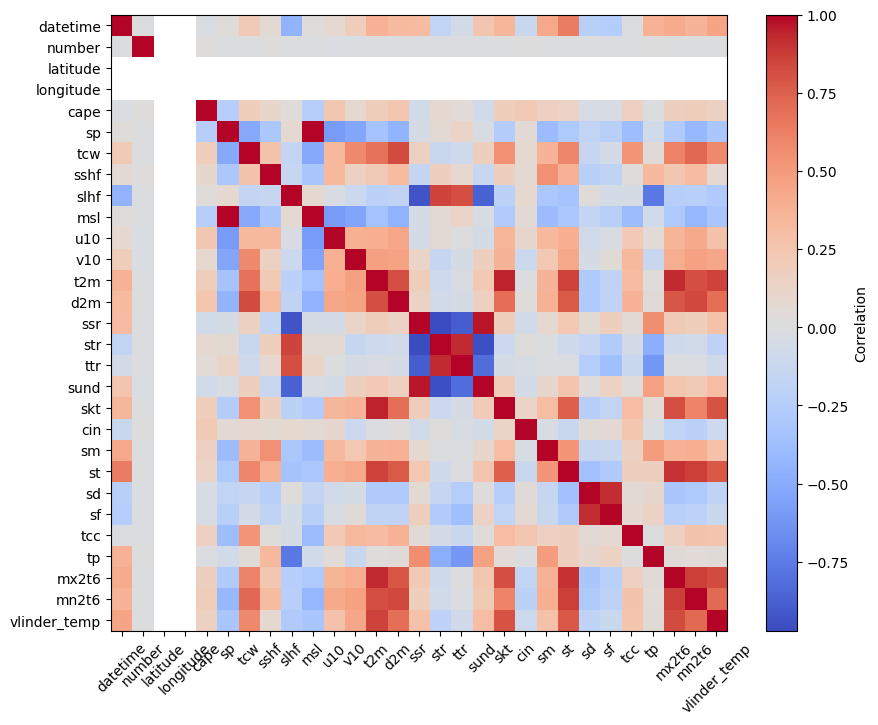

In [10]:
def display_corr_matrix(df):
    corr_matrix = df.corr() 
    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest') 
    plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
    plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
    plt.colorbar(label='Correlation')
    plt.show()

display_corr_matrix(df_fc_merged)

In [11]:
correlations = df_fc_merged.corr()['vlinder_temp'].sort_values(ascending=False).drop('vlinder_temp')
correlations

t2m          8.590063e-01
mx2t6        8.277742e-01
skt          8.017925e-01
st           7.832985e-01
mn2t6        7.075287e-01
d2m          6.945393e-01
tcw          5.768815e-01
datetime     4.477332e-01
v10          4.339333e-01
sund         3.006282e-01
ssr          2.829146e-01
sm           2.797375e-01
u10          2.715560e-01
tcc          2.463270e-01
cape         1.507762e-01
sshf         8.265974e-02
tp           4.450580e-02
number      -1.126980e-15
ttr         -8.210670e-02
cin         -9.405954e-02
sf          -1.095322e-01
sd          -1.931452e-01
str         -1.962731e-01
slhf        -2.724708e-01
sp          -3.094875e-01
msl         -3.182836e-01
latitude              NaN
longitude             NaN
Name: vlinder_temp, dtype: float64

Without surprise we can see from the correlation matrix that the features from the ensemble forecast that are highly correlated with the vlinder temperature are those measuring some kind of temperature (t2m, d2m, mx2t6, mn2t6,..). However those variables are also heavily cross-correlated, which means that we might want to drop them later. 

Latitude and longitude are constant values that hold no explicative power, we will drop them later

We also need to check for NaN values.


In [12]:
#Display columns that have NaN values and percentage of NaN values
def nan_info(df):
    for column in which_col_nan(df):
        nan_percent = get_nan_percent(df[column], df.shape[0])
        print(f"{column} has {nan_percent * 100:.2f} % of NaN values" )
        
#Returns list of Columns that have nan values
def which_col_nan(df):
    return df.columns[df.isna().any()].tolist()

def get_nan_percent(df_col, df_entries):
    return df_col.isna().sum() / df_entries

nan_info(df_fc_merged)

cin has 85.21 % of NaN values
mx2t6 has 4.71 % of NaN values
mn2t6 has 4.71 % of NaN values


We can see that cin has a large amount of NaN values and mx2t6 and mn2t6 have smaller amount, we will definitevely drop cin, but we could extrapolate mx2t6 if they appear to be interesting

In [13]:
# Returns list of columns who have a number of unique features = 1 (=> all the same values)
# from https://studymachinelearning.com/pandas-how-to-remove-dataframe-columns-with-constant-same-values/
def constant_value_features_columns(df):
    return [e for e in df.columns if df[e].nunique() == 1]

def remove_cst_values(df):
    to_keep = [e for e in df.columns if e not in constant_value_features_columns(df)]
    return df[to_keep]

# Drop all columns that have NaN values or that are constant.
df_fc_merged.dropna(axis=1, how='any', inplace=True)
df_fc_merged = remove_cst_values(df_fc_merged)
df_fc_merged

,datetime,number,cape,sp,tcw,sshf,slhf,msl,u10,v10,...,ttr,sund,skt,sm,st,sd,sf,tcc,tp,vlinder_temp
0,2023-03-01,1,0.000000,102126.210,6.714889,-117.5,-127.0,103096.090,-0.985653,-1.660708,...,0.0,0.00,269.20410,347.42044,275.79584,0.000000,0.000000,1.556484,9.536743e-07,0.4
1,2023-03-01,2,0.000000,102133.650,6.498146,-117.5,-127.0,103103.970,-1.522217,-2.057304,...,0.0,0.00,269.66020,338.56020,275.89400,0.000000,0.000000,0.000000,9.536743e-07,0.4
2,2023-03-01,3,0.000000,102119.945,6.799605,-117.5,-127.0,103089.580,-1.284668,-1.731162,...,0.0,0.00,269.31256,350.98910,275.68307,0.000000,0.000000,0.781292,9.536743e-07,0.4
3,2023-03-01,4,0.000000,102120.590,7.023780,-117.5,-127.0,103091.086,-1.273917,-1.996072,...,0.0,0.00,269.56317,358.10077,275.86673,0.000000,0.000000,0.781292,9.536743e-07,0.4
4,2023-03-01,5,0.000000,102109.240,6.827844,-117.5,-127.0,103079.080,-1.361147,-1.904866,...,0.0,0.00,269.51580,340.47208,275.64920,0.000000,0.000000,1.556484,9.536743e-07,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,2023-04-15,46,11.805359,98736.100,13.910993,-1478017.2,-29733878.0,99656.630,6.333741,1.094811,...,-88390510.0,112789.70,279.11590,402.91540,280.54153,0.000000,0.000000,99.999435,2.248534e+01,14.1
8496,2023-04-15,47,-0.000015,99851.650,7.535722,-975426.0,-30657344.0,100784.770,1.825381,-3.670377,...,-88522590.0,116340.81,276.48553,416.41345,279.61438,0.000412,0.141889,8.745297,3.348900e+01,14.1
8497,2023-04-15,48,-0.000015,100653.480,11.031565,-4055575.0,-32969068.0,101578.670,-0.277234,1.778796,...,-90826590.0,153523.75,274.23380,388.12820,280.26746,0.000741,0.031643,2.243168,2.123952e+01,14.1
8498,2023-04-15,49,6.307617,99093.445,16.348476,-2412107.5,-31490452.0,100018.234,0.170359,-7.688744,...,-89472280.0,139842.00,278.04886,418.53656,279.88376,0.000000,0.000000,99.999435,2.660018e+01,14.1


# Spliting train, validation and test data

When creating our different sets, if we randomly split our data we also separate a given ensemble forecast into our different sets.

We need a special function that rounds up the the 50th closest observation to keep ensemble forecasts together in each set. 
At the moment we select a given percentage and round up to the closest value that is a multiple of 50, that way we get only whole ensemble forecasts.
We also need to select only from a given date onwards, this means that our test set is at one end of our set.

In [14]:
y = df_fc_merged['vlinder_temp']

#TODO might need to keep datetime for later use
#We need to drop datetime to call fit_tranform
X = df_fc_merged.drop(columns=['vlinder_temp', 'datetime'])

In [15]:
from sklearn.model_selection import train_test_split

# Function used to round up to the 50th closest value to avoid splitting different samples
# Returns number of entries to select
def get_nb_entries(df, percent):
    return math.floor(df.shape[0] * percent / 50) * 50

# With shuffle=False we use only the end -> the entries at the end is split if we take a "random" percentage
# We need to round up to a percentage that keeps time stamp whole
# Split the training set into new training and validation sets (~ 80% training, ~20% test)
nb_test_entries = get_nb_entries(X, 0.8)
X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(X, y, train_size=nb_test_entries, shuffle=False)

# Split the training set into new training and validation sets (~75% training, ~25% validation)
nb_validation_entries = get_nb_entries(X_train_tmp, 0.75)
X_train, X_val, y_train, y_val = train_test_split(X_train_tmp, y_train_tmp, train_size=nb_validation_entries, shuffle=False)
X_train.to_csv('tmp.csv')

In [16]:
#TODO, scale or not ?
#Need to scale the data 
#from sklearn.preprocessing import StandardScaler 

#scaler_x = StandardScaler().fit(X_train)
#X_scale = scaler_x.transform(X_train)

In [17]:
# TODO: automate to select the best k
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

#TODO probably need to drop highly cross related values -> Multicolineraty (not really as they measure the same thing)
#At what treshhold should i throw out values?
# Do we use multiple factor regression?
selector = SelectKBest(k=1, score_func=f_regression)
X_selected = selector.fit_transform(X_train.values, y_train.values)
cols_idxs = selector.get_support(indices=True)
features_df_new = X_train.iloc[:,cols_idxs]
print(features_df_new)

            t2m
0     271.34305
1     271.92282
2     271.54650
3     271.77940
4     271.71695
...         ...
5095  278.74430
5096  279.43842
5097  279.44577
5098  278.68290
5099  280.48770

[5100 rows x 1 columns]


# Simple solution

"Least-squares regression is applied on training data to estimate a linear relationship between predictions and corresponding observations" from _Vannitsem, S., Wilks, D. S., & Messner, J. W. (Elsevier). (2018). Statistical Postprocessing of Ensemble Forecasts_

We build a set with $tmp_{observed}$, $tmpfc_{1},\ \ldots, \ tmpfc_{50}$, data, ensemble mean and ensemble sdd

In [18]:
# returns set that contains observed temperatures, forecast temperatures, ensemble mean and ensemble ssd 
def aggregate_transpose(df):
    df = df[['t2m', 'datetime']]
    # groups t2m entries in one datetime entry
    df_datetime = df.groupby('datetime').apply(lambda x: x.reset_index(drop=True))
    #creating one column entry per t2m value
    df_unstacked = df_datetime.unstack()
    #dropping datetime as group by has been done
    df_unstacked.drop(columns='datetime', inplace=True)
    return df_unstacked

df_simple_solution_transposed = aggregate_transpose(df_fc_merged)

#Insert vlinder temperatures into transposed dataframe, match data on datetime
df_vlinder_datetime_index = df_vlinder_res_first.set_index('datetime')
assert df_vlinder_datetime_index.index.equals(df_simple_solution_transposed.index), f"Indices (=> datetime) of transposed df and resampled vlinder should match\n GOT {df_vlinder_datetime_index.index}\n EXPECTED {df_simple_solution_transposed.index}"

df_simple_solution_transposed['ensmean'] = df_simple_solution_transposed.mean(axis=1)
df_simple_solution_transposed['enssd'] = df_simple_solution_transposed.std(axis=1)
df_simple_solution_transposed['temp_vlinder'] = df_vlinder_datetime_index[:]

#df_simple_solution = pd.concat([df_vlinder_datetime_index, df_simple_solution_transposed], axis=1)
#df_simple_solution.rename(columns={'temp': 'temp_vlinder', inplace=True)
df_simple_solution_transposed['temp_vlinder'] = df_simple_solution_transposed['temp_vlinder'] + C_0
df_simple_solution = df_simple_solution_transposed

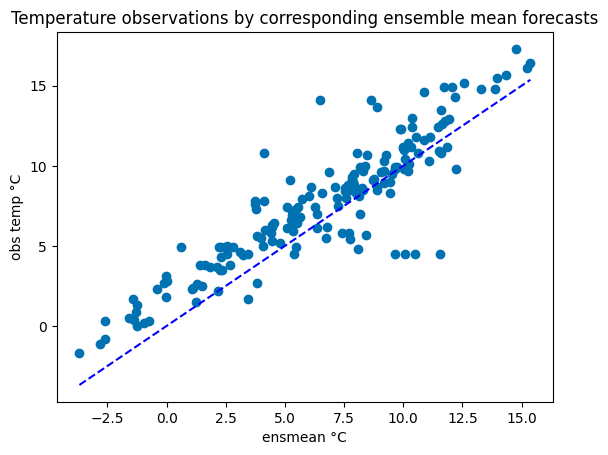

In [19]:
x = np.linspace(min(df_simple_solution['ensmean'] - C_0), max(df_simple_solution['ensmean'] - C_0))
y = x

plt.scatter(df_simple_solution['ensmean'] - C_0, df_simple_solution['temp_vlinder'] - C_0, marker='o')
plt.plot(x , y, linestyle='--', color='blue', label='x = y')
plt.xlabel("ensmean °C")
plt.ylabel("obs temp °C")
plt.title('Temperature observations by corresponding ensemble mean forecasts')
plt.show()

We can see that we have a negative bias in our ensemble forecast as most of our data points are above the x = y line

In [20]:
X = df_simple_solution['ensmean'].values.reshape(-1, 1)
y = df_simple_solution['temp_vlinder'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from codecarbon import EmissionsTracker

def train_model(model, X_train, y_train, tracker):
    tracker.start()
    try:
        model.fit(X_train, y_train)
    finally:
        tracker.stop()
    return model

@track_emissions()
def train_model_2(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

tracker = EmissionsTracker()

#model = train_model(LinearRegression(), X_train, y_train, tracker)
model = train_model_2(LinearRegression(), X_train, y_train)

y_pred = model.predict(X_test)

print("Coefficients:", model.coef_)

# Print the mean squared error
print("Mean squared error:", mean_squared_error(y_test, y_pred))

# Print the coefficient of determination (R^2 score)
print("Coefficient of determination (R^2 score):", r2_score(y_test, y_pred))

[codecarbon INFO @ 11:20:47] [setup] RAM Tracking...
[codecarbon INFO @ 11:20:47] [setup] GPU Tracking...
[codecarbon INFO @ 11:20:47] No GPU found.
[codecarbon INFO @ 11:20:47] [setup] CPU Tracking...
[codecarbon WARNING @ 11:20:48] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:20:48] CPU Model on constant consumption mode: Apple M1
[codecarbon INFO @ 11:20:48] >>> Tracker's metadata:
[codecarbon INFO @ 11:20:48]   Platform system: macOS-14.0-arm64-arm-64bit
[codecarbon INFO @ 11:20:48]   Python version: 3.11.7
[codecarbon INFO @ 11:20:48]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 11:20:48]   Available RAM : 8.000 GB
[codecarbon INFO @ 11:20:48]   CPU count: 8
[codecarbon INFO @ 11:20:48]   CPU model: Apple M1
[codecarbon INFO @ 11:20:48]   GPU count: None
[codecarbon INFO @ 11:20:48]   GPU model: None
[codecarbon INFO @ 11:20:51] [setup] RAM Tracking...
[codecarbon INFO @ 11:20:51] [setup] GPU Tracking...
[codecarbon INFO @ 11:20:51] No GPU

Coefficients: [[0.86109559]]
Mean squared error: 2.5790096529139426
Coefficient of determination (R^2 score): 0.8297762126428474


When selecting only one week our result are less precise as above
**!!! Conclusion drawn from test set as both have not been conducted in parrallel**

We need to take only one week with LOOCV and compare it to the whole data set with LOOCV

Linear Regression if only one week is selected
- Coefficients: [[0.76954526]]
- Mean squared error: 3.2674047991823643
- Coefficient of determination (R^2 score): 0.691794647528979


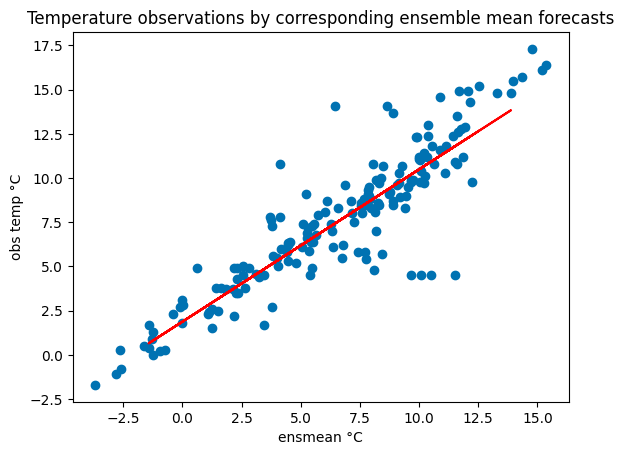

In [22]:
plt.scatter(df_simple_solution['ensmean'] - C_0, df_simple_solution['temp_vlinder'] - C_0, marker='o')
plt.plot(X_test - C_0, y_pred - C_0, color='red', label='regression')
plt.xlabel("ensmean °C")
plt.ylabel("obs temp °C")
plt.title('Temperature observations by corresponding ensemble mean forecasts')
plt.show()

# Correcting forecast

In [23]:
import re

def keep_digits(str):
    pattern = r'\D+' 
    return re.sub(pattern, '', str)

input_csv = "Forecast_16_03_2024.csv"
to_digits = keep_digits(input_csv)
output_csv_str = "Corr-" + to_digits[4:] + to_digits[2:4] + to_digits[:2] + "_TheBlaze.csv"
to_correct = pd.read_csv(f"weekly_forecast/{input_csv}")
to_correct = to_correct[['time', 'number', 't2m']]

to_correct.rename(columns={'time': 'datetime'}, inplace=True)
transposed = aggregate_transpose(to_correct)
transposed.reset_index(inplace=True)
transposed_datetime = transposed['datetime']
transposed.drop(columns='datetime', inplace=True)

df_corrected_t2m = transposed.copy()
for index, row in df_corrected_t2m.iterrows(): 
    y_row = model.predict(row.values.reshape(-1, 1))
    #squeeze to reshap np array into one dimension
    df_corrected_t2m.iloc[index] = np.squeeze(y_row)

df_corrected_t2m['datetime'] = transposed_datetime
df_corrected_t2m.set_index('datetime', inplace=True)


/var/folders/lw/bnynzkxj0cq2wnbmqw0rvyzh0000gn/T/ipykernel_39801/1187255596.py:17: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  transposed.drop(columns='datetime', inplace=True)


In [24]:
print(to_correct[['datetime', 't2m']])

# reshapes corrected temperatures values to have same format as to_correct
df_reshaped = df_corrected_t2m.T.melt(var_name='datetime', value_name='t2m')

to_correct['t2m'] = df_reshaped['t2m']

df_corrected = to_correct

df_corrected.rename(columns={"datetime": "time"}, inplace=True)


df_corrected.to_csv(f"weekly_corrected/{output_csv_str}")

                 datetime        t2m
0     2024-03-16 00:00:00  283.13223
1     2024-03-16 00:00:00  283.05984
2     2024-03-16 00:00:00  283.01965
3     2024-03-16 00:00:00  283.18338
4     2024-03-16 00:00:00  283.27676
...                   ...        ...
1445  2024-03-23 00:00:00  281.72867
1446  2024-03-23 00:00:00  277.61075
1447  2024-03-23 00:00:00  281.03827
1448  2024-03-23 00:00:00  278.13123
1449  2024-03-23 00:00:00  281.75912

[1450 rows x 2 columns]


# Tests of CodeCarbon
Synthetic neural network, used to check power consumption using CodeCarbon packet

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a Multi-layer Perceptron Classifier
clf = MLPClassifier(hidden_layer_sizes=(100, 5), activation='relu', solver='adam', max_iter=500, random_state=42)

train_model_2(clf, X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[codecarbon INFO @ 11:20:54] [setup] RAM Tracking...
[codecarbon INFO @ 11:20:54] [setup] GPU Tracking...
[codecarbon INFO @ 11:20:54] No GPU found.
[codecarbon INFO @ 11:20:54] [setup] CPU Tracking...
[codecarbon WARNING @ 11:20:54] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:20:54] CPU Model on constant consumption mode: Apple M1
[codecarbon INFO @ 11:20:54] >>> Tracker's metadata:
[codecarbon INFO @ 11:20:54]   Platform system: macOS-14.0-arm64-arm-64bit
[codecarbon INFO @ 11:20:54]   Python version: 3.11.7
[codecarbon INFO @ 11:20:54]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 11:20:54]   Available RAM : 8.000 GB
[codecarbon INFO @ 11:20:54]   CPU count: 8
[codecarbon INFO @ 11:20:54]   CPU model: Apple M1
[codecarbon INFO @ 11:20:54]   GPU count: None
[codecarbon INFO @ 11:20:54]   GPU model: None
[codecarbon INFO @ 11:20:55] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 11:20:55

Accuracy: 0.825
